In [148]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [149]:
# read in all the words
words = open('/Users/deancasey/Downloads/Datasets/makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [150]:
len(words)

32033

In [151]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [152]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [153]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [154]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [155]:
C = torch.randn((27,2))

In [156]:
C[5]

tensor([ 0.9253, -3.2305])

In [157]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.9253, -3.2305])

In [158]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [159]:
emb[0].shape, emb[1]

(torch.Size([3, 2]),
 tensor([[ 1.1505, -1.2914],
         [ 1.1505, -1.2914],
         [ 0.9253, -3.2305]]))

In [110]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [111]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [112]:
h.shape

torch.Size([228146, 100])

In [113]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [114]:
logits = h @ W2 + b2

In [115]:
logits.shape

torch.Size([228146, 27])

In [116]:
counts = logits.exp()

In [117]:
prob = counts / counts.sum(1, keepdims=True)

In [118]:
prob.shape

torch.Size([228146, 27])

In [119]:
loss = -prob[torch.arange(len(X)), Y].log().mean()
loss

tensor(15.2878)

In [120]:
# Respectable

In [121]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [122]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [123]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [124]:
for p in parameters:
    p.requires_grad = True

In [125]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [126]:
lri = []
lossi = []
stepi = []

In [139]:
for i in range(300000):
    
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item())

1.894893765449524


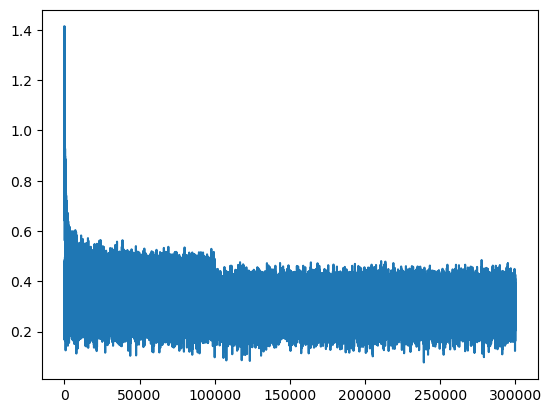

In [140]:
plt.plot(stepi,lossi)

In [141]:
emb = C[Xtr] # (len(Xtr), 3, 10)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0414, grad_fn=<NllLossBackward0>)

In [142]:
emb = C[Xdev] # (len(Xdev), 3, 10)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1173, grad_fn=<NllLossBackward0>)

In [143]:
emb = C[Xte] # (len(Xte), 3, 10)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1223, grad_fn=<NllLossBackward0>)

In [78]:
# 2.17 test loss is the number to beat!

In [79]:
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center',va='center',color='white')
# plt.grid('minor')

In [80]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [147]:
# sample from model

block_size = 3

g = torch.Generator().manual_seed(2147483647 + 17)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

kaziyah.
mony.
hir.
ahan.
hal.
callyana.
shyrahadriilana.
daves.
soriene.
sofiylanne.
ylah.
haslaya.
kancety.
nalif.
aubra.
jazmara.
adraycei.
ruhamarshadshis.
abin.
mison.
